# this module will implement a 3D renderer for cubes
# ideally, code this so that it is not that hard to make it in verilog

In [186]:
from IPython.display import display 
from PIL import Image

In [187]:
# definitions
# these are defined beforehand
# the e will be dynamic in the future (it is the head position)

u = (1, 0, 0)
v = (0, 1, 0)
e = (1800.0001, 1800.001, -300) # put it farther away from the plane to adjust for distortion, adjust not to be exact so artifacts don't appear
w = 1024
h = 768

w = int(1024/4)
h = int(768/4)

dx = w
dy = h

# these are sorted by distance
blocks_pos = [(1800, 1800, 700), (1800 + dx, 1800, 800), (1800 - dx, 1800 - dy, 800), (1800 - dx, 1800 + dy, 900), (1800 + dx, 1800 + dy, 901)]
blocks_mat = [(1, 0, 0, 0.7), (0, 0, 1, 0.7), (1, 0.5, 0.5, 0.7), (1, 0.5, 0.5, 0.2), (0.5, 0.5, 0.5, 0.2)] # ranges from 0 to 1, diffuse RGB and reflection
lights_pos = [(1400, 1800, 100), (1800, 1800, 100), (2200, 1800, 100)]
lights_intense = [(0.25, 0.5, 0.25), (0.75, 0.5, 0.75), (0.25, 0.5, 0.25)] # colored lights

In [188]:
# import image
img = Image.new("RGB", (w, h))

In [189]:
# display image
def display_image():
    display(img)

In [190]:
# def zero_image():
#     for i in range(img.size[0]):
#         for j in range(img.size[1]):
#             img.putpixel((i, j), (0, 0, 0))

In [191]:
# helper functions

# implement these via modules; specify a valid bit output
def scale(v, c):
    return (v[0] * c, v[1] * c, v[2] * c)
def size(v):
    return dot(v, v)**0.5
def add(v1, v2):
    return (v1[0] + v2[0], v1[1] + v2[1], v1[2] + v2[2])
def sub(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1], v1[2] - v2[2])
def dot(v1, v2):
    return (v1[0] * v2[0]) + (v1[1] * v2[1]) + (v1[2] * v2[2])
def normalize(v):
    v_size = size(v)
    size_inv = 1 / v_size
    return scale(v, size_inv)
def less_than(a, b):
    return a < b
def less_than_equal(a, b):
    return a <= b

In [192]:
def eye_to_pixel(x, y):
    # TODO: future, need to incorporate rotation into this algorithm
    # right now, it will follow the player, but it will never rotate
    proj_plane_top_left = (e[0] - w/2, e[1] - h/2, 100) # ints
    scale_u = scale(u, x)
    scale_v = scale(v, y)
    sum_scales = add(scale_u, scale_v)
    proj_plane_point = add(sum_scales, proj_plane_top_left)
    dir = sub(proj_plane_point, e)
    dir = normalize(dir)
    return dir

In [193]:
def does_ray_block_intersect(ray, block_pos, t):    
    BLOCK_SIZE = 100
    block_min = sub(block_pos, (BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
    block_max = add(block_pos, (BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))

    tmin = -10000000
    tmax = 10000000

    for i in range(3):
        if ray[i] != 0:
            min_e = block_min[i] - e[i]
            max_e = block_max[i] - e[i]
            tx1 = min_e / ray[i]
            tx2 = max_e / ray[i]

            min_tx12_lt = less_than(tx1, tx2) # tx1 < tx2 ? tx1 : tx2
            max_tx12_lt = less_than(tx2, tx1) # tx2 < tx1 ? tx1 : tx2

            tmin = max(tmin, tx1 if min_tx12_lt else tx2)
            tmax = min(tmax, tx1 if max_tx12_lt else tx2)
    
    # tmin <= tmax
    if less_than_equal(tmin, tmax):
        t[0] = tmin
        return True
    else:
        return False

In [194]:
def get_pixel_color(block_pos, block_mat, ray, t):
    newOrigin = add(e, scale(ray, t[0]))
    normal = sub(newOrigin, block_pos)
    normal_magnitude = size(normal)

    if normal == 0:
        return (0, 0, 0)
    
    normal = scale(normal, 1/normal_magnitude)

    r = 0.0
    g = 0.0
    b = 0.0
    for i in range(len(lights_pos)):
        light_pos = lights_pos[i]
        light_intense = lights_intense[i]
        dist = sub(light_pos, newOrigin)

        if dot(normal, dist) <= 0:
            continue
        
        rayDir = scale(dist, 1/size(dist))

        lambert = dot(rayDir, normal)

        r += (light_intense[0] * block_mat[0] * lambert)
        g += (light_intense[1] * block_mat[1] * lambert)
        b += (light_intense[2] * block_mat[2] * lambert)

    return r, g, b

def set_pixel_color(block_pos, block_mat, ray, x, y, t):
    r, g, b = get_pixel_color(block_pos, block_mat, ray, t)
    r = int(min(r, 1) * 255.0)
    g = int(min(g, 1) * 255.0)
    b = int(min(b, 1) * 255.0)
    # print(f"SET PIXEL {r}, {g}, {b}")
    img.putpixel((x, y), (r, g, b))

# print(get_pixel_color((1800, 1800, 200), (1, 0, 0, 0.5), eye_to_pixel(w/2, h/2), t))

In [195]:
def render_frame():
    for y in range(h):
        for x in range(w):
            ray = eye_to_pixel(x, y)
            t = [1000000000]

            block = -1

            for i in range(len(blocks_pos)):
                if does_ray_block_intersect(ray, blocks_pos[i], t):
                    block = i
                    break
            
            if block == -1:
                img.putpixel((x, y), (0, 0, 0))
                continue

            set_pixel_color(blocks_pos[block], blocks_mat[block], ray, x, y, t)

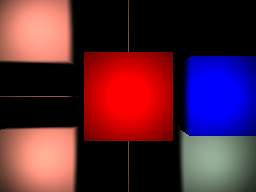

In [196]:
render_frame()
display_image()

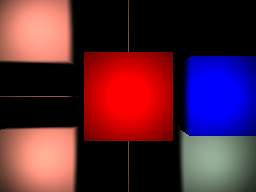

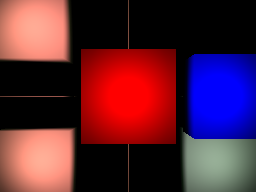

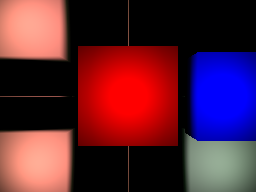

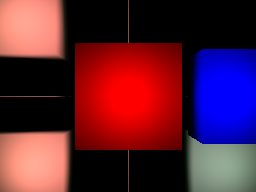

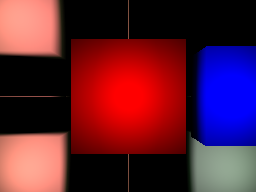

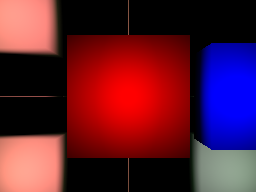

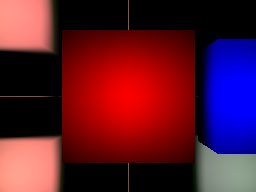

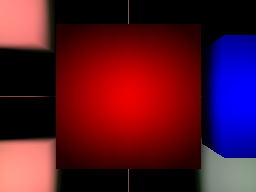

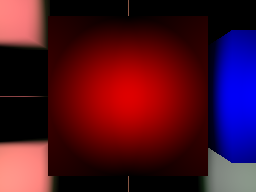

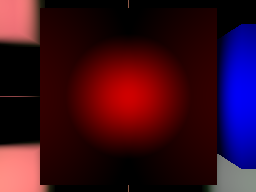

In [197]:
do_random = True

if do_random:
    import random
    # blocks_pos = [(1800, 1800, 700)]
    # blocks_mat = [(1, 0, 0, 0.7)]
    # for j in range(random.randint(5, 20)):
    #     if random.randint(0, 1) == 0:
    #         blocks_pos.append((1800 + random.randint(-w, w), 1800 + random.randint(-h, h), blocks_pos[-1][2] + 32))
    #         if random.randint(0, 1) == 0:
    #             blocks_mat.append((1, 0, 0, 1))
    #         else:
    #             blocks_mat.append((0, 0, 1, 1))

    for i in range(10):
        render_frame()
        display_image()
        
        for j in range(len(blocks_pos)):
            # blocks_pos[j] = (blocks_pos[j][0] + random.randint(-16, 16), blocks_pos[j][1] + random.randint(-16, 16), blocks_pos[j][2] - 50)
            blocks_pos[j] = (blocks_pos[j][0] + 0, blocks_pos[j][1] + 0, blocks_pos[j][2] - 50)